In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/sus/simplified.csv")
df.head()

,data,internacoes
0,1969-03-03,2
1,1971-01-09,2
2,1972-10-16,24
3,1973-01-12,2
4,1989-04-03,2


In [3]:
def preparar_dados_agregados(df, data_col, valor_col, ano_minimo, ano_maximo):
    df[data_col] = pd.to_datetime(df[data_col], errors='coerce')
    df = df.dropna(subset=[data_col, valor_col])
    df = df[
        (df[data_col].dt.year >= ano_minimo) & 
        (df[data_col].dt.year < ano_maximo)
    ]
    df = df.iloc[1:]
    df = df.set_index(data_col).sort_index()
    return df[[valor_col]]

def executar_pipeline_forecast(df, data_col, valor_col, ano_minimo, ano_maximo):
    return preparar_dados_agregados(df, data_col, valor_col, ano_minimo, ano_maximo)

In [4]:
series = executar_pipeline_forecast(df, data_col='data', valor_col='internacoes', ano_minimo=2008, ano_maximo=2023)

# 1. Pré-processamento dos Dados
- Verificar se os dados estão completos
- Identificar e tratar valores ausentes

In [5]:
series['internacoes'].isna().sum()

np.int64(0)

In [6]:
data_inicio = series.index.min()
data_fim = series.index.max()
index_esperado = pd.date_range(start=data_inicio, end=data_fim, freq='D')

dias_faltantes = index_esperado.difference(series.index)

if len(dias_faltantes) == 0:
    print("✅ Nenhum dia faltando na série temporal.")
else:
    print(f"❌ {len(dias_faltantes)} dias estão faltando.")
    print("Exemplo de datas ausentes:", dias_faltantes[:10])

✅ Nenhum dia faltando na série temporal.


# 2. Análise Exploratória
- Plotar a série temporal para visualizar tendência e sazonalidade
- Decompor a série em componentes (tendência, sazonalidade, resíduo)
- Testar estacionariedade (Teste ADF ou KPSS)
- Analisar autocorrelação (ACF/PACF)

# 3. Modelagem
Opções de modelos:
- ARIMA/SARIMA: Bom para séries com padrões claros
- ETS: Modelos de suavização exponencial
- Prophet: Desenvolvido pelo Facebook, lida bem com sazonalidade
- Redes Neurais (LSTM): Para padrões complexos
- Regressão com variáveis externas: Se tiver outros dados relevantes

# 4. Validação
- Dividir em treino/teste (ex: treino até 2018, teste 2019-2022)
- Calcular métricas de erro (MAE, RMSE, MAPE)
- Comparar performance dos diferentes modelos

# 5. Previsão (Forecast)
- Treinar o modelo escolhido com todos os dados disponíveis
- Fazer previsões para o período desejado (ex: próximo ano)
- Calcular intervalos de confiança

In [7]:
## 1. Funções de Análise Exploratória --------------------------------------------------------

def plot_series(series, title='Série Temporal', xlabel='Data', ylabel='Valor'):
    """Plota uma série temporal."""
    plt.figure(figsize=(14, 6))
    plt.plot(series.index, series.values, marker='o', linestyle='', markersize=2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def decompose_series(series, model='additive', period=365):
    """
    Decompõe a série temporal em componentes:
    tendência, sazonalidade e resíduo.
    """
    try:
        decomposition = seasonal_decompose(series, model=model, period=period)
        decomposition.plot()
        plt.tight_layout()
        plt.show()
        return decomposition
    except Exception as e:
        print(f"Erro na decomposição: {e}")
        return None

def test_stationarity(series):
    """Realiza o teste ADF de estacionariedade."""
    result = adfuller(series.dropna())
    print('Teste ADF de Estacionariedade:')
    print(f'Estatística ADF: {result[0]}')
    print(f'p-valor: {result[1]}')
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result

def plot_acf_pacf(series, lags=30):
    """Plota as funções de autocorrelação e autocorrelação parcial."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(series, ax=ax1, lags=lags)
    plot_pacf(series, ax=ax2, lags=lags)
    plt.tight_layout()
    plt.show()

## 2. Funções de Modelagem e Avaliação -----------------------------------------------------

def train_test_split(series, test_size=0.2):
    """Divide a série em conjuntos de treino e teste."""
    split_idx = int(len(series) * (1 - test_size))
    train = series.iloc[:split_idx]
    test = series.iloc[split_idx:]
    return train, test

def fit_arima(train, order=(1,1,1), seasonal_order=(0,0,0,0)):
    """Ajusta um modelo ARIMA/SARIMA aos dados."""
    model = ARIMA(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit

def evaluate_model(model, train, test):
    """Avalia o modelo nos dados de teste."""
    # Previsão
    forecast = model.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Métricas
    mae = mean_absolute_error(test, forecast_mean)
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    
    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train, label='Treino')
    plt.plot(test.index, test, label='Real')
    plt.plot(test.index, forecast_mean, label='Previsão')
    plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.1)
    plt.legend()
    plt.title('Desempenho do Modelo - Conjunto de Teste')
    plt.show()
    
    return forecast_mean, conf_int

def make_future_forecast(model, series, steps=30):
    """Gera previsões para períodos futuros."""
    forecast = model.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Gerar datas futuras
    future_dates = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=steps)
    
    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(series.index, series, label='Dados Históricos')
    plt.plot(future_dates, forecast_mean, label='Previsão', color='red')
    plt.fill_between(future_dates,
                    conf_int.iloc[:,0],
                    conf_int.iloc[:,1],
                    color='red', alpha=0.1)
    plt.title('Previsão Futura')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return forecast_mean, conf_int

## 3. Função Principal de Análise ----------------------------------------------------------

def analyze_time_series(series, test_size=0.2, future_steps=60):
    """
    Executa análise completa de série temporal:
    1. Análise exploratória
    2. Modelagem ARIMA
    3. Avaliação
    4. Previsão futura
    """
    print("\n" + "="*50)
    print("ANÁLISE EXPLORATÓRIA")
    print("="*50)
    # 1. Análise Exploratória
    plot_series(series, title='Série Temporal Original')
    decomposition = decompose_series(series)
    test_stationarity(series)
    plot_acf_pacf(series)
    
    # 2. Preparação dos dados
    train, test = train_test_split(series, test_size=test_size)
    
    print("\n" + "="*50)
    print("MODELAGEM ARIMA")
    print("="*50)
    # 3. Modelagem - ajuste esses parâmetros conforme necessário
    model = fit_arima(train, 
                     order=(1,1,1), 
                     seasonal_order=(1,1,1,7))  # Sazonalidade semanal
    
    print("\n" + "="*50)
    print("AVALIAÇÃO DO MODELO")
    print("="*50)
    # 4. Avaliação
    forecast_test, _ = evaluate_model(model, train, test)
    
    print("\n" + "="*50)
    print("PREVISÃO FUTURA")
    print("="*50)
    # 5. Previsão futura
    final_model = fit_arima(series, 
                          order=(1,1,1), 
                          seasonal_order=(1,1,1,7))
    forecast_future, _ = make_future_forecast(final_model, series, steps=future_steps)
    
    return {
        'model': final_model,
        'test_forecast': forecast_test,
        'future_forecast': forecast_future,
        'decomposition': decomposition
    }


ANÁLISE EXPLORATÓRIA


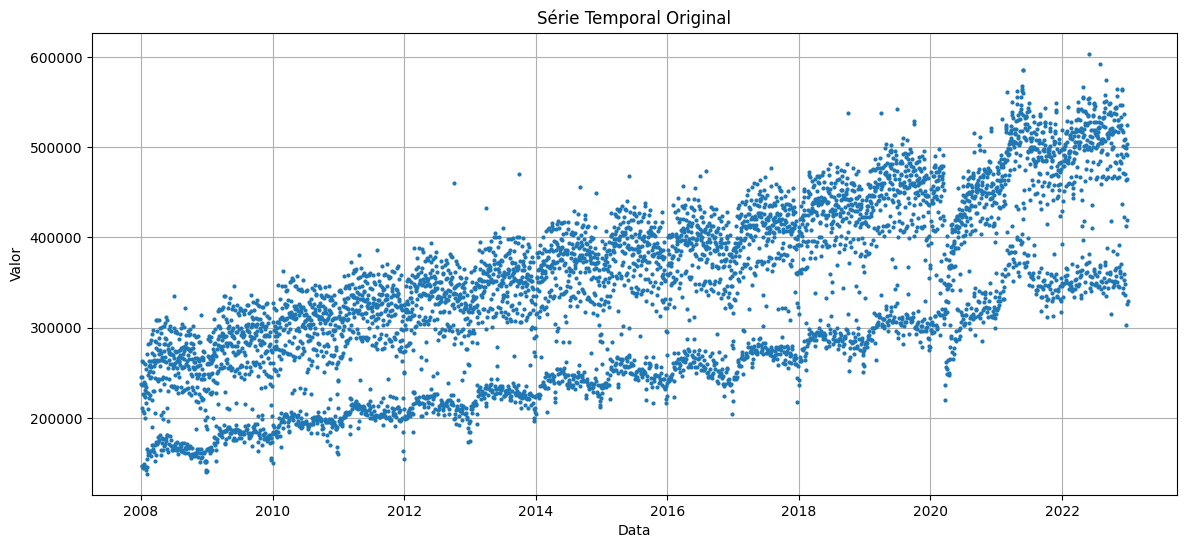

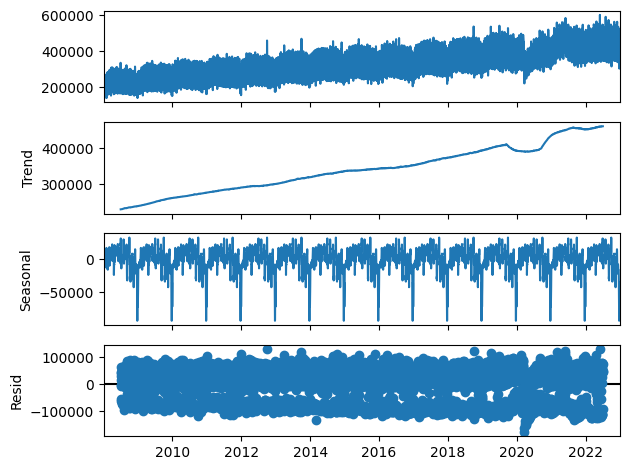

Teste ADF de Estacionariedade:
Estatística ADF: -1.8893045417075223
p-valor: 0.33710919893842006
Valores Críticos:
   1%: -3.4315517608513493
   5%: -2.862071057878025
   10%: -2.5670526811133167


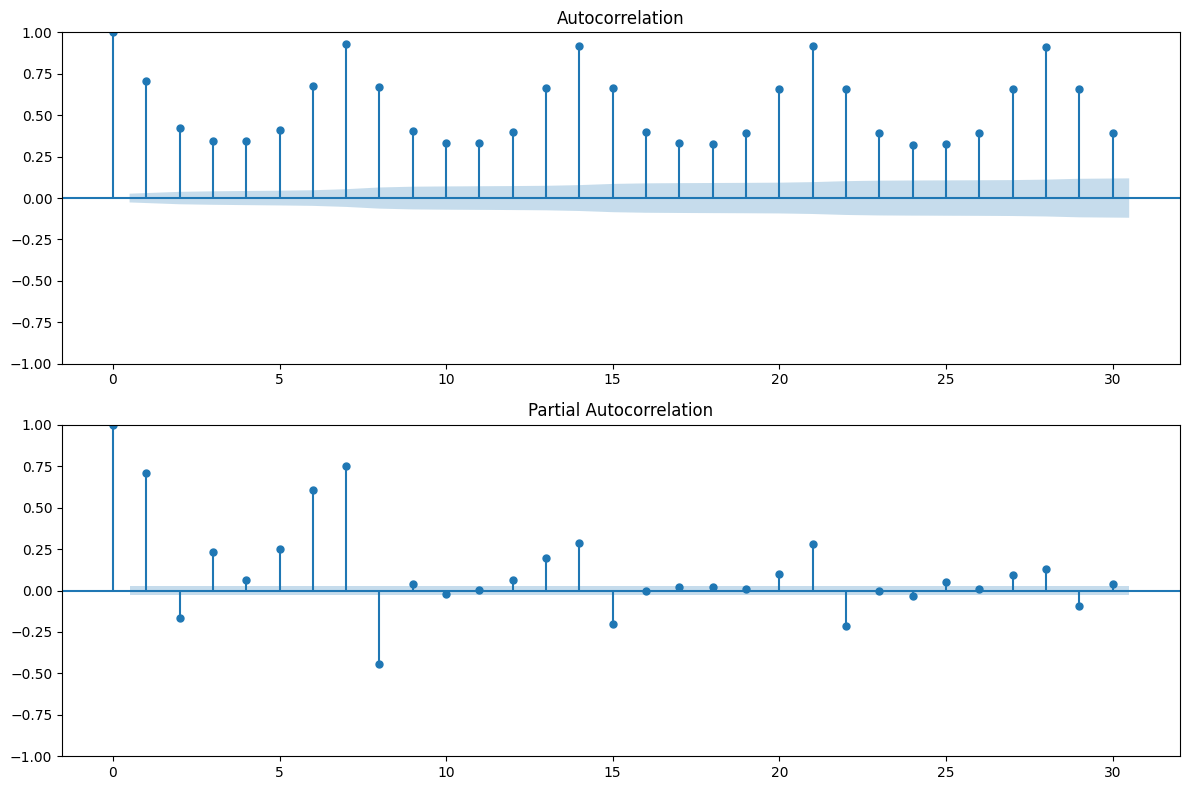


MODELAGEM ARIMA
                                    SARIMAX Results                                    
Dep. Variable:                     internacoes   No. Observations:                 4382
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -50395.515
Date:                         Sat, 28 Jun 2025   AIC                         100801.030
Time:                                 14:51:57   BIC                         100832.947
Sample:                             01-02-2008   HQIC                        100812.292
                                  - 12-31-2019                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5454      0.019     28.301      0.000       0.508       0.583
ma.L1         -0.9611      0.011    -88.34

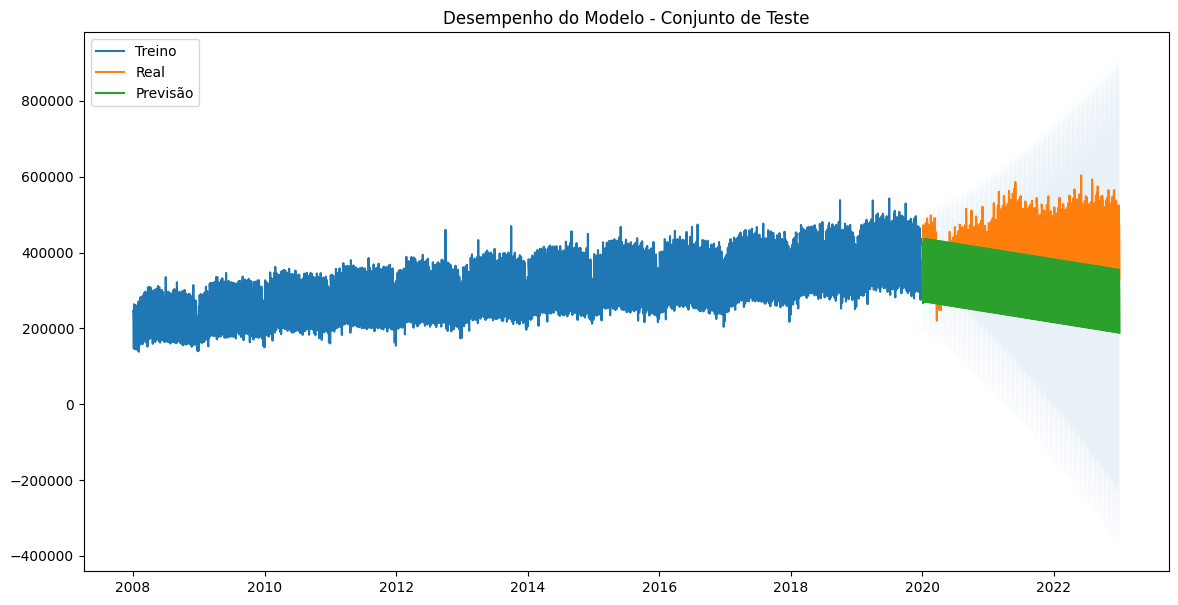


PREVISÃO FUTURA
                                    SARIMAX Results                                    
Dep. Variable:                     internacoes   No. Observations:                 5478
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -63142.294
Date:                         Sat, 28 Jun 2025   AIC                         126294.588
Time:                                 14:51:58   BIC                         126327.623
Sample:                             01-02-2008   HQIC                        126306.113
                                  - 12-31-2022                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5424      0.018     30.950      0.000       0.508       0.577
ma.L1         -0.9579      0.010    -96.86

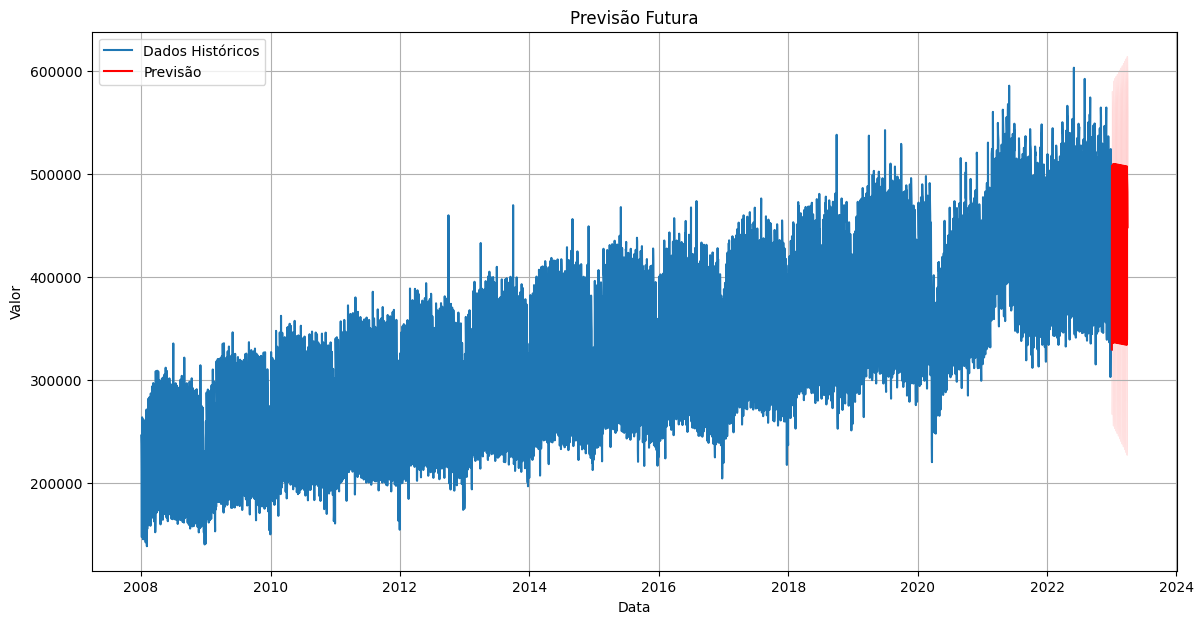

In [8]:
results = analyze_time_series(series, test_size=0.2, future_steps=90)

# Análise do Modelo ARIMA para Internações Diárias

## Resultados do Teste de Estacionariedade (ADF)
- **Estatística ADF**: -1.889  
- **p-valor**: 0.337  
- **Valores críticos**:
  - 1%: -3.432
  - 5%: -2.862
  - 10%: -2.567

**Conclusão**:  
A série **não é estacionária** (p-valor > 0.05) → Diferenciação (d=1) foi necessária e aplicada

---

## Diagnóstico do Modelo ARIMA(1,1,1)×(1,1,1,7)

### Coeficientes Significativos:
| Parâmetro | Valor    | z-score  | Significância |
|-----------|----------|----------|---------------|
| ar.L1     | 0.5454   | 28.301   | p < 0.001     |
| ma.L1     | -0.9611  | -88.345  | p < 0.001     |
| ar.S.L7   | 0.1030   | 4.506    | p < 0.001     |
| ma.S.L7   | -0.9786  | -142.031 | p < 0.001     |

### Problemas Identificados:
1. **Alerta numérico**: Matriz de covariância near-singular (condition number 6.99e+34)
2. **Heteroscedasticidade**: Teste H rejeitado (p ≈ 0.00)
3. **Não-normalidade**: JB=18059.48 (p=0.00), Kurtose=12.59, Assimetria=-1.34

---

## Performance do Modelo
| Métrica | Valor     | Interpretação |
|---------|-----------|---------------|
| MAE     | 111,329.57| Erro médio de ~111k internações |
| RMSE    | 123,804.81| Erros grandes influenciam mais |

**Comparativo**:  
- Dados variam entre 200k-600k → **Erros representam 18-55% dos valores reais**

---

In [9]:
# 2. Modelagem com Prophet (Facebook)
def prophet_forecast(df, forecast_periods=365, changepoints=True):
    """Modelagem com Prophet que lida bem com sazonalidades múltiplas"""
    # Preparar dados
    df_prophet = df.reset_index()
    df_prophet.columns = ['ds', 'y']
    
    # Configurar modelo
    model = Prophet(
        daily_seasonality=False,  # Para dados diários
        weekly_seasonality=True,  # Sazonalidade semanal
        yearly_seasonality=True,  # Sazonalidade anual
        changepoint_prior_scale=0.05 if changepoints else 0.001,
        seasonality_mode='additive'
    )
    
    # Adicionar feriados (opcional)
    # model.add_country_holidays(country_name='BR')
    
    # Treinar modelo
    model.fit(df_prophet)
    
    # Criar dataframe futuro
    future = model.make_future_dataframe(periods=forecast_periods, freq='D')
    
    # Previsão
    forecast = model.predict(future)
    
    return model, forecast

# 3. Avaliação do Modelo
def evaluate_prophet(model, forecast, train_size=0.8):
    """Avaliação do modelo Prophet com a nova API"""
    # Cross-validation (ATUALIZADO)
    try:
        df_cv = cross_validation(
            model,
            initial='730 days',  # 2 anos de treino
            period='180 days',    # intervalo entre cortes
            horizon='90 days',    # período de previsão
            parallel="processes"
        )
        
        df_p = performance_metrics(df_cv)
        
        print("\nMétricas de Performance:")
        print(df_p[['horizon', 'mae', 'mape', 'rmse']].head())
        
        # Plot dos resultados
        from prophet.plot import plot_cross_validation_metric
        plot_cross_validation_metric(df_cv, metric='mape')
        plt.show()
        
    except Exception as e:
        print(f"\nErro na validação cruzada: {e}")
        df_p = None
    
    # Plot dos componentes
    fig1 = model.plot(forecast)
    plt.title('Previsão com Prophet')
    
    fig2 = model.plot_components(forecast)
    plt.show()
    
    return df_p


=== MODELAGEM COM PROPHET ===


14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing



=== AVALIAÇÃO DO MODELO ===


14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] done processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] done processing
14:52:00 - cmdstanpy - INFO - Chain [1] done processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] done processing
14:52:00 - cmdstanpy - INFO - Chain


Métricas de Performance:
  horizon           mae      mape          rmse
0  9 days  19600.801980  0.056545  28565.880835
1 10 days  20944.058053  0.060755  30873.525250
2 11 days  21376.942015  0.062916  31549.356572
3 12 days  21654.714153  0.063940  32131.829384
4 13 days  22108.010099  0.065585  32704.043043


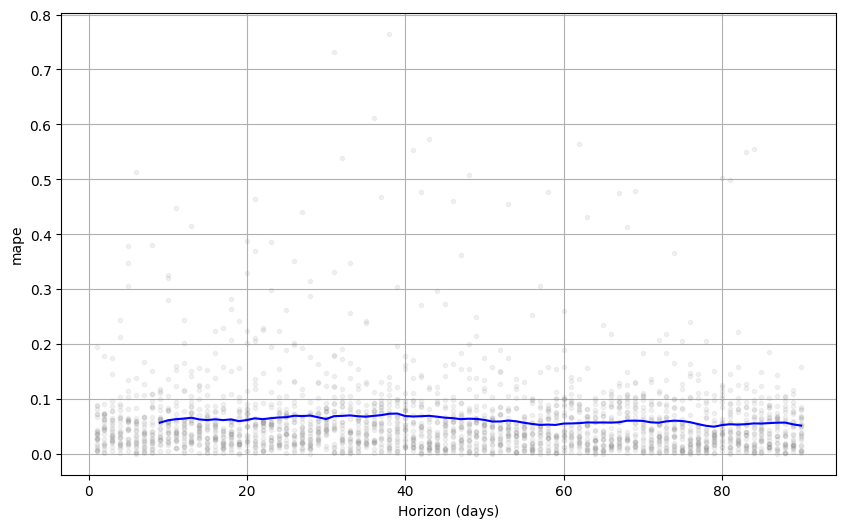

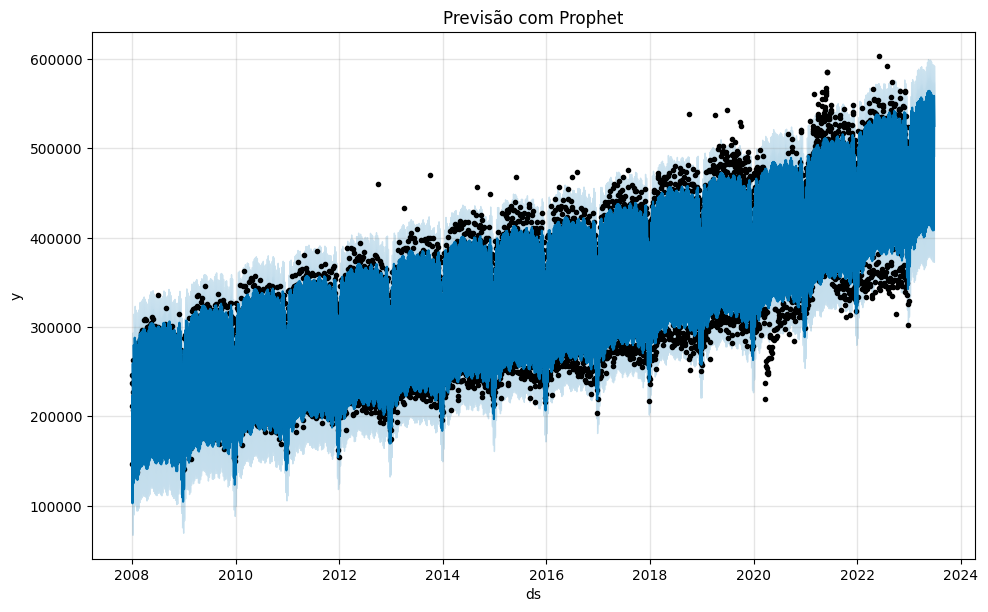

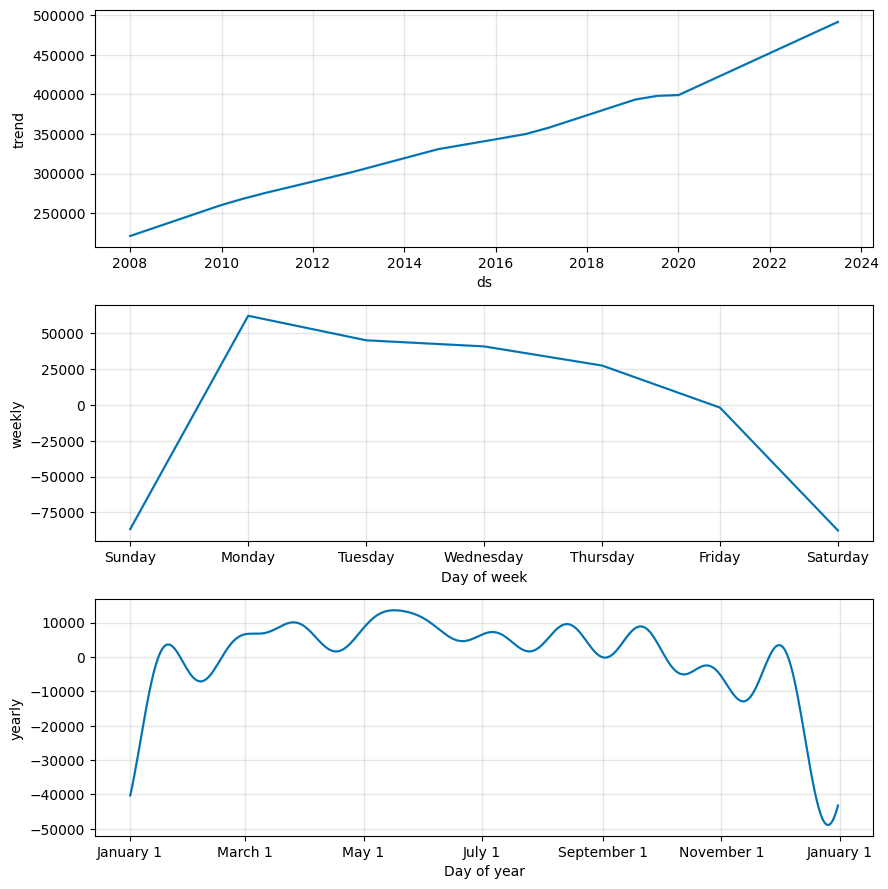

In [10]:
# Modelagem
print("\n=== MODELAGEM COM PROPHET ===")
periods=180
model, forecast = prophet_forecast(series, periods)

# Avaliação
print("\n=== AVALIAÇÃO DO MODELO ===")
metrics = evaluate_prophet(model, forecast)

# Análise das Métricas Prophet
### 1. MAPE (Mean Absolute Percentage Error)
- Faixa: 5.6% a 6.6%
- **Interpretação:** Para cada previsão, o erro médio está entre 5.6% e 6.6% do valor real
- **Classificação:** Moderado (em saúde, <5% seria ideal)

### 2. MAE (Mean Absolute Error)
- Faixa: 19,600 a 22,100 internações
- Deve ser comparado com a média histórica de internações

### 3. RMSE (Root Mean Squared Error)
- Faixa: 28,500 a 32,700
- Mais sensível a outliers que MAE